In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

ca_models_lib_mac = "/Users/scini/Documents/GitHub/Systems_Bio/ca_models_lib.py" 
ca_models_lib_path = ca_models_lib_mac  # Change this if on a different system

# Add the directory containing ca_models_lib.py to sys.path
import sys
import os
if ca_models_lib_path not in sys.path:
    sys.path.append(os.path.dirname(ca_models_lib_path))

import ca_models_lib as caml

import pandas as pd
import time


# import libraries
import torch
from torch_geometric.nn import GCNConv, ChebConv, GATConv, RGCNConv # , DCRNNConv
from torch_geometric.data import Data, DataLoader # , temporal_signal_split

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
import networkx as nx

In [3]:
# Load data
folder_path_pc = r"C:\Users\steph\Box\ZartmanLabGroupFolder\Zartman_Dowling\Stephen\MC2021_Data"
folder_path_mac = r"/Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data"

folder_path = folder_path_mac
# Get geometry files

# Select size
size = 'xsmall'  # Options: 'xsmall', 'small', 'medium', 'large',
# Load statics for wing disc geometries    
disc_vertices = np.load(os.path.join(folder_path, "geometry", "disc_vertices.npy"), allow_pickle=True).item()  # Vertices
disc_laplacians = np.load(os.path.join(folder_path, "geometry", "disc_sizes_laplacian.npy"), allow_pickle=True).item()  # Laplacian Matrix
disc_adjs = np.load(os.path.join(folder_path, "geometry", "disc_sizes_adj.npy"), allow_pickle=True).item()  # Adjacency matrix

adj_matrix=disc_adjs[size] # Adjacency Matrix
laplacian_matrix=disc_laplacians[size] # Laplacian Matrix
new_vertices=disc_vertices[size] # Vertices

# Number of cells
num_cells = new_vertices.shape[0]

In [4]:
import torch_geometric
# Get edge index and edge weights from laplacian matrix
# Get nondiagonal elements of laplacian matrix
off_diag_lap = laplacian_matrix - np.diag(np.diag(laplacian_matrix))
display(off_diag_lap)

is_symmetric = np.allclose(off_diag_lap, off_diag_lap.T)
print("Symmetric?", is_symmetric)

row, col = np.nonzero(off_diag_lap)
# np.array(row)
# np.array(col)

edge_index = torch.tensor([row, col], dtype=torch.long)
print(edge_index)
print(edge_index.shape)  # Should be [2, num_edges]
edge_weight = torch.tensor(off_diag_lap[row, col], dtype=torch.float32)


print(edge_weight)
print(edge_weight.shape)  # Should be [num_edges,]




array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 10.19337977],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 10.19337977,
         0.        ,  0.        ]], shape=(195, 195))

Symmetric? True
tensor([[  0,   0,   1,  ..., 194, 194, 194],
        [  3,   5,   3,  ..., 188, 189, 192]])
torch.Size([2, 1064])
tensor([ 8.6643,  9.5087,  8.8120,  ...,  8.8206,  7.3286, 10.1934])
torch.Size([1064])


/var/folders/v2/s6clf_y12bjd0pq98kr66skw0000gs/T/ipykernel_59697/3498145600.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636709/work/torch/csrc/utils/tensor_new.cpp:281.)
  edge_index = torch.tensor([row, col], dtype=torch.long)


In [9]:
import torch
from torch_geometric.data import Data, Dataset


class SlidingWindowTemporalDataset(Dataset):
    """
    General-purpose sliding window dataset for temporal graph data.

    Parameters
    ----------
    Ca : array-like, shape (N, T)
        Node values over time. Can be numpy array or torch tensor.
        N = number of nodes, T = number of timepoints.
    edge_index : torch.LongTensor, shape (2, E)
        Graph connectivity (same for all timesteps).
    in_window : int, default=1
        Number of past timepoints to use as input (window size).
    horizon : int, default=1
        How many steps ahead of the LAST input frame to start predicting.
        Example: in_window=5, horizon=1:
            x uses t .. t+4, y starts at t+5.
    out_window : int, default=1
        Number of future timepoints to predict.
        out_window=1 → single-step target
        out_window>1 → sequence-to-sequence target.
    """

    def __init__(self, Ca, edge_index, in_window=1, horizon=1, out_window=1):
        super().__init__()

        # Ensure tensor, keep as float
        self.Ca = torch.as_tensor(Ca, dtype=torch.float)  # (N, T)
        self.edge_index = edge_index

        assert self.Ca.ndim == 2, "Ca must have shape (N, T)"
        self.N, self.T = self.Ca.shape

        self.in_window = int(in_window)
        self.horizon = int(horizon)
        self.out_window = int(out_window)

        assert self.in_window >= 1
        assert self.horizon >= 1
        assert self.out_window >= 1

        # How many samples can we make?
        # idx is the *start index* of the input window.
        #
        # Input uses       [idx, ..., idx + in_window - 1]
        # Last input idx = idx + in_window - 1
        # First target    = last_input + horizon
        #                = idx + in_window - 1 + horizon
        # Last target     = first_target + out_window - 1
        #                = idx + in_window - 1 + horizon + out_window - 1
        #
        # Require last_target <= T - 1
        # => idx <= T - (in_window + horizon + out_window) + 1
        self._max_start_idx = (
            self.T - (self.in_window + self.horizon + self.out_window) + 1
        )
        if self._max_start_idx <= 0:
            raise ValueError(
                f"Not enough timepoints T={self.T} for "
                f"in_window={self.in_window}, horizon={self.horizon}, out_window={self.out_window}"
            )

    def len(self):
        # Number of valid window starts
        return self._max_start_idx

    def get(self, idx):
        """
        idx: integer in [0, len(self)-1]
        Defines the *start* of the input window.
        """
        if idx < 0 or idx >= self.len():
            raise IndexError(f"Index {idx} out of range for dataset of length {self.len()}")

        # Input window: [idx, ..., idx + in_window - 1]
        x_start = idx
        x_end = idx + self.in_window  # slicing is exclusive, so this is +in_window

        # Target window:
        # first target index = last_input + horizon
        y_start = (idx + self.in_window - 1) + self.horizon
        y_end = y_start + self.out_window

        # Shapes:
        # x: (N, in_window)
        # y: (N, out_window)
        x = self.Ca[:, x_start:x_end]
        y = self.Ca[:, y_start:y_end]

        return Data(
            x=x,                 # (N, in_window)
            y=y,                 # (N, out_window)
            edge_index=self.edge_index
        )



## Load CRC sim data

['ca_model_dense_sim1_20251202-011440.csv', 'ca_model_dense_sim1_20251202-011535.csv', 'ca_model_dense_sim1_20251202-011331.csv', 'ca_model_dense_sim2_20251202-011535.csv', 'ca_model_dense_sim3_20251202-011535.csv', 'ca_model_dense_sim1_20251202-011442.csv', 'ca_model_dense_sim1_params_543210_20251202-011629.txt', 'ca_model_dense_sim1_20251202-011242.csv', 'ca_model_dense_base_42_20251202-011535.csv', 'ca_model_dense_sim1_params_42_20251202-011535.txt', 'ca_model_dense_base_528491_20251202-011331.csv', 'ca_model_dense_sim1_20251202-011622.csv', 'ca_model_dense_base_528492_20251202-011442.csv', 'ca_model_dense_sim1_params_1234_20251202-011213.txt', 'ca_model_dense_base_123567_20251202-011302.csv', 'ca_model_dense_sim1_params_123_20251202-011242.txt', 'ca_model_dense_base_543210_20251202-011629.csv', 'ca_model_dense_sim1_20251202-011629.csv', 'ca_model_dense_base_54321_20251202-011622.csv', 'ca_model_dense_sim1_20251202-011213.csv', 'ca_model_dense_sim2_params_42_20251202-011535.txt', 'c

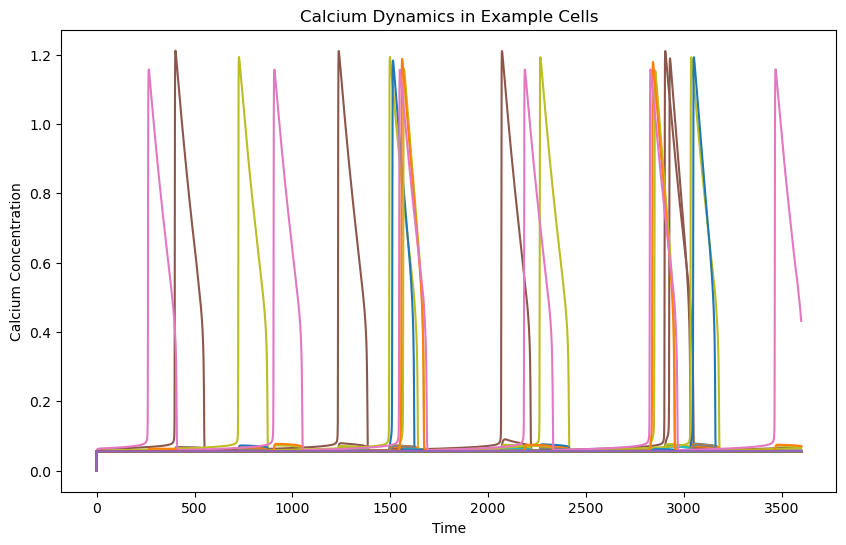

In [10]:
results_path = os.path.join(folder_path, "ML_data_gen_CRC", "usable_12012025_r2")

# Show files in results_path
files = os.listdir(results_path)
print(files)

# Load one of the simulation results
sim_data = pd.read_csv(os.path.join(results_path, "ca_model_dense_base_42_20251202-011535.csv"))
print(sim_data.head())

# Extract calcium data
ca_data = sim_data.filter(like='Cell').to_numpy()
print(ca_data.shape)  # (time_points, num_cells)

# Plot example cells
time_points = ca_data.shape[0]
time_vector = np.arange(time_points)
plt.figure(figsize=(10, 6))
for cell_idx in range(num_cells):  # Plot first 5 cells
    plt.plot(time_vector, ca_data[:, cell_idx], label=f'Cell {cell_idx}')
plt.xlabel('Time')
plt.ylabel('Calcium Concentration')
plt.title('Calcium Dynamics in Example Cells')


# Save calcium as a numpy array
ca_data_path = os.path.join(results_path, "ca_data.npy")
np.save(ca_data_path, ca_data)
print(f"Calcium data saved to {ca_data_path}")

print("Length of files:", len(files))
                                

In [12]:
seeds = [42, 123, 1234, 12345, 123456, 123567, 231171, 270103, 528491, 1235678]
round2_path = os.path.join(folder_path, "ML_data_gen_CRC", "round2_120225")

# Load all data files and compile into a single dataset
window_size = 1  # Number of past timepoints to use as input
horizon = 1      # Steps ahead to start predicting
out_window = 1   # Number of future timepoints to predict


# round 2 has a folder for each seed. open folder, load files, build datasets
for seed in seeds:
    # Find folder with seed in name
    seed_folder = None
    for item in os.listdir(round2_path):
        if f"_{seed}_" in item and os.path.isdir(os.path.join(round2_path, item)):
            seed_folder = os.path.join(round2_path, item)
            print(f"Found seed folder: {seed_folder}")
            # Load all csv files in this folder
            seed_files = os.listdir(seed_folder)
            for file_name in seed_files:
                if file_name.endswith('.csv'):
                    file_path = os.path.join(seed_folder, file_name)
                    print(f"Processing file: {file_path}")
                    sim_data = pd.read_csv(file_path)
                    ca_data = sim_data.filter(like='Cell').to_numpy()
                    # Verify shape
                    print(f"Calcium data shape for {file_name}: {ca_data.shape}")
                    # Transpose to (N, T)
                    ca_data = ca_data.T
                    print(f"Transposed calcium data shape for {file_name}: {ca_data.shape}")

                    
                    # Create dataset
                    dataset = SlidingWindowTemporalDataset(
                        Ca=ca_data,
                        edge_index=edge_index,
                        in_window=window_size,
                        horizon=horizon,
                        out_window=out_window
                    )
                    print(f"Created dataset with {len(dataset)} samples from {file_name}")

                    # Save dataset object as a torch file
                    results_path_torch2 = os.path.join(folder_path, "ML_data_gen_CRC", f"round2_120225_torch_seed_{seed}")
                    dataset_path = os.path.join(results_path_torch2, f"{file_name[:-4]}_PyGT_dataset_{window_size}{horizon}{out_window}.pt")
                    torch.save(dataset, dataset_path)
                    print(f"Saved dataset to {dataset_path}")

    

Found seed folder: /Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/ML_data_gen_CRC/round2_120225/r2_results_42_20251202-180122
Processing file: /Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/ML_data_gen_CRC/round2_120225/r2_results_42_20251202-180122/ca_model_dense_sim23_20251202-180122.csv
Calcium data shape for ca_model_dense_sim23_20251202-180122.csv: (3600, 195)
Transposed calcium data shape for ca_model_dense_sim23_20251202-180122.csv: (195, 3600)
Created dataset with 3598 samples from ca_model_dense_sim23_20251202-180122.csv
Saved dataset to /Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/ML_data_gen_CRC/round2_120225_torch_seed_42/ca_model_dense_sim23_20251202-180122_PyGT_dataset_111.pt
Processing file: /Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/ML_data_gen_CRC/round2_

In [20]:
# Load all data files and compile into a single dataset
window_size = 5  # Number of past timepoints to use as input
horizon = 1      # Steps ahead to start predicting
out_window = 5   # Number of future timepoints to predict
results_path_torch = os.path.join(folder_path, "ML_data_gen_CRC", "usable_12012025_torch")

all_ca_data = []
for file_name in files:
    if file_name.endswith('.csv'):
        sim_data = pd.read_csv(os.path.join(results_path, file_name))
        ca_data = sim_data.filter(like='Cell').to_numpy()
        ca_data = ca_data.T
        all_ca_data.append(ca_data)
        # check shape
        print(f"Loaded {file_name} with shape {ca_data.shape}")
        # Make Rolling Window Dataset
        dataset = SlidingWindowTemporalDataset(
            Ca=ca_data,
            edge_index=edge_index,
            in_window=window_size,
            horizon=horizon,
            out_window=out_window
        )
        print(f"Created dataset with {len(dataset)} samples from {file_name}")

        # Save dataset object as a torch file
        dataset_path = os.path.join(results_path_torch, f"{file_name[:-4]}_PyGT_dataset_{window_size}{horizon}{out_window}.pt")
        torch.save(dataset, dataset_path)
        print(f"Saved dataset to {dataset_path}")


        




# # Concatenate all data along the time axis
# compiled_ca_data = np.concatenate(all_ca_data, axis=0)
# print(f"Compiled calcium data shape: {compiled_ca_data.shape}")


Loaded ca_model_dense_sim1_20251202-011440.csv with shape (195, 3600)
Created dataset with 3590 samples from ca_model_dense_sim1_20251202-011440.csv
Saved dataset to /Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/ML_data_gen_CRC/usable_12012025_torch/ca_model_dense_sim1_20251202-011440_PyGT_dataset_515.pt
Loaded ca_model_dense_sim1_20251202-011535.csv with shape (195, 3600)
Created dataset with 3590 samples from ca_model_dense_sim1_20251202-011535.csv
Saved dataset to /Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/ML_data_gen_CRC/usable_12012025_torch/ca_model_dense_sim1_20251202-011535_PyGT_dataset_515.pt
Loaded ca_model_dense_sim1_20251202-011331.csv with shape (195, 3600)
Created dataset with 3590 samples from ca_model_dense_sim1_20251202-011331.csv
Saved dataset to /Users/scini/Library/CloudStorage/Box-Box/ZartmanLabGroupFolder/Zartman_Dowling/Stephen/MC2021_Data/ML_data_gen_CR

In [ ]:
# Sklearn train test split
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(compiled_ca_data, test_size=0.2, random_state=42)
print(f"Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")

# sklearn random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# --- IGNORE ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# Reshape data for sklearn (samples, features)

Train data shape: (63360, 195), Test data shape: (15840, 195)
